Loading models...
Evaluating English model...


Evaluating English:   0%|          | 0/13023 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Evaluating English:  34%|███▍      | 4488/130

*** WARNING: max output size exceeded, skipping output. ***

Evaluating English: 100%|██████████| 13023/13023 [01:42<00:00, 127.08it/s]


Evaluating Kannada model...


Evaluating Kannada:   9%|▉         | 477/5422 [00:03<00:36, 134.69it/s]

Error processing example 57316b0de6313a140071cf14: Truncation error: Sequence to truncate too short to respect the provided max_length


Evaluating Kannada: 100%|██████████| 5422/5422 [00:42<00:00, 127.54it/s]



Evaluation Results:

English Model Performance:
  Exact Match (EM): 64.95%
  F1 Score: 79.10%

Kannada Model Performance:
  Exact Match (EM): 40.21%
  F1 Score: 55.97%

Performance Comparison:
  EM Difference: 24.74%
  F1 Difference: 23.13%

Generating performance visualizations...


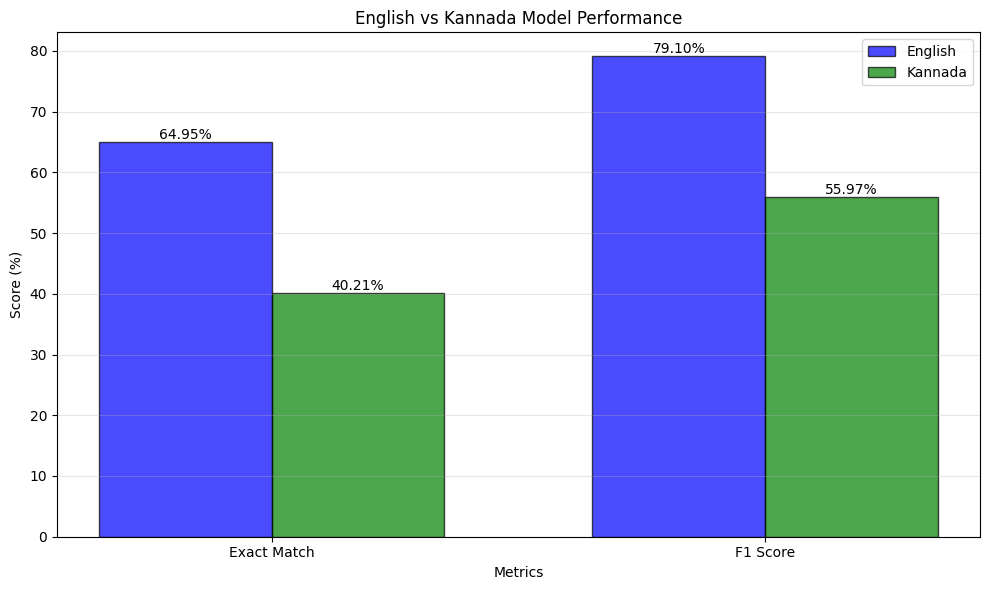

Saved: model_performance_comparison.png
Saved: model_performance_results.csv
Saved: detailed_results.txt

Sample Predictions:

English Model Examples:

Example 1:
Question: When was the The English Roses published?
Ground Truth: September 2003
Prediction: September 2003

Example 2:
Question: What organization oversees India's technical education institutions?
Ground Truth: AICTE
Prediction: AICTE

Example 3:
Question: What is another term for Bharatam?
Ground Truth: Unified India
Prediction: Unified India

Kannada Model Examples:

Example 1:
Question: ರಾಣಿ ಎಲಿಜಬೆತ್ II ಯನ್ನು ಪ್ರತಿನಿಧಿಸುವವರು ಯಾರು?
Ground Truth: ಕೆನಡಾದ ಗವರ್ನರ್ ಜನರಲ್
Prediction: ಗವರ್ನರ್ ಜನರಲ್

Example 2:
Question: 1880ರ ದಶಕದಲ್ಲಿ ಯಾವ ಸ್ಪರ್ಧಾತ್ಮಕ ರೈಲ್ವೆ ಕಂಪನಿ ರೈಲ್ವೆ ಮಾರ್ಗವನ್ನು ತೆರೆಯಲು ಪ್ರಯತ್ನಿಸಿತು?
Ground Truth: ಡಿಕೋಟ್, ನ್ಯೂಬರಿ ಮತ್ತು ಸೌತ್ ಹ್ಯಾಂಪ್ಟನ್ ರೈಲ್ವೆ
Prediction: ಡಿಕೋಟ್, ನ್ಯೂಬರಿ ಮತ್ತು ಸೌತ್ ಹ್ಯಾಂಪ್ಟನ್ ರೈಲ್ವೆ

Example 3:
Question: ಡೌ ವೂ ವಿರುದ್ಧ ದೇಶದ್ರೋಹ ಆರೋಪಗಳನ್ನು ಯಾರು ಮಾಡಿದರು?
Ground Truth: ಜನರಲ್ ಝಾಂಗ್ ಹುವಾನ್
Prediction:

In [0]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from datasets import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter

def normalize_answer(s):
    def remove_articles(text):
        return ' '.join([word for word in text.split() if word.lower() not in ('a', 'an', 'the')])
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in string.punctuation)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def compute_f1(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_squad_metrics(predictions, references):
    exact_match = []
    f1_scores = []
    for pred, ref in zip(predictions, references):
        pred_text = pred['prediction_text']
        ref_texts = ref['answers']['text']
        em = max(compute_exact_match(pred_text, ref_text) for ref_text in ref_texts)
        f1 = max(compute_f1(pred_text, ref_text) for ref_text in ref_texts)
        exact_match.append(em)
        f1_scores.append(f1)
    return {
        'exact_match': 100.0 * sum(exact_match) / len(exact_match),
        'f1': 100.0 * sum(f1_scores) / len(f1_scores)
    }

print("Loading models...")
tokenizer = AutoTokenizer.from_pretrained("/Volumes/afti_dev_catalog/s3_buckets/databricks-afti-dev/Adithya/tmp/model_english_final")
model_eng = AutoModelForQuestionAnswering.from_pretrained("/Volumes/afti_dev_catalog/s3_buckets/databricks-afti-dev/Adithya/tmp/model_english_final")
model_kan = AutoModelForQuestionAnswering.from_pretrained("/Volumes/afti_dev_catalog/s3_buckets/databricks-afti-dev/Adithya/tmp/model_kannada_final")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_eng.to(device)
model_kan.to(device)

qa_pipeline_eng = pipeline("question-answering", model=model_eng, tokenizer=tokenizer, device=0 if device=="cuda" else -1)
qa_pipeline_kan = pipeline("question-answering", model=model_kan, tokenizer=tokenizer, device=0 if device=="cuda" else -1)

def evaluate_model(test_data, qa_pipeline, lang='English'):
    print(f"Evaluating {lang} model...")

    predictions = []
    references = []

    for example in tqdm(test_data, desc=f"Evaluating {lang}"):
        try:
            result = qa_pipeline(
                question=example['question'],
                context=example['context']
            )

            predictions.append({
                'id': example['id'],
                'prediction_text': result['answer']
            })

            references.append({
                'id': example['id'],
                'answers': example['answers']
            })
        except Exception as e:
            print(f"Error processing example {example['id']}: {e}")
            predictions.append({
                'id': example['id'],
                'prediction_text': ''
            })
            references.append({
                'id': example['id'],
                'answers': example['answers']
            })

    results = compute_squad_metrics(predictions, references)

    return results, predictions, references

eng_results, eng_predictions, eng_references = evaluate_model(eng_test, qa_pipeline_eng, lang='English')
kan_results, kan_predictions, kan_references = evaluate_model(kan_test, qa_pipeline_kan, lang='Kannada')

print("\nEvaluation Results:")
print(f"\nEnglish Model Performance:")
print(f"  Exact Match (EM): {eng_results['exact_match']:.2f}%")
print(f"  F1 Score: {eng_results['f1']:.2f}%")

print(f"\nKannada Model Performance:")
print(f"  Exact Match (EM): {kan_results['exact_match']:.2f}%")
print(f"  F1 Score: {kan_results['f1']:.2f}%")

print(f"\nPerformance Comparison:")
print(f"  EM Difference: {eng_results['exact_match'] - kan_results['exact_match']:.2f}%")
print(f"  F1 Difference: {eng_results['f1'] - kan_results['f1']:.2f}%")

print("\nGenerating performance visualizations...")

metrics = ['Exact Match', 'F1 Score']
english_scores = [eng_results['exact_match'], eng_results['f1']]
kannada_scores = [kan_results['exact_match'], kan_results['f1']]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, english_scores, width, label='English', color='blue', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, kannada_scores, width, label='Kannada', color='green', alpha=0.7, edgecolor='black')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score (%)')
ax.set_title('English vs Kannada Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: model_performance_comparison.png")

results_summary = pd.DataFrame({
    'Model': ['English', 'Kannada'],
    'Exact Match (%)': [eng_results['exact_match'], kan_results['exact_match']],
    'F1 Score (%)': [eng_results['f1'], kan_results['f1']],
    'Training Samples': [len(eng_train), len(kan_train)],
    'Test Samples': [len(eng_test), len(kan_test)]
})

results_summary.to_csv('model_performance_results.csv', index=False)
print("Saved: model_performance_results.csv")

with open('detailed_results.txt', 'w', encoding='utf-8') as f:
    f.write("DETAILED MODEL EVALUATION RESULTS\n\n")

    f.write("ENGLISH MODEL PERFORMANCE\n")
    f.write(f"Exact Match: {eng_results['exact_match']:.2f}%\n")
    f.write(f"F1 Score: {eng_results['f1']:.2f}%\n")
    f.write(f"Training samples: {len(eng_train)}\n")
    f.write(f"Validation samples: {len(eng_val)}\n")
    f.write(f"Test samples: {len(eng_test)}\n\n")

    f.write("KANNADA MODEL PERFORMANCE\n")
    f.write(f"Exact Match: {kan_results['exact_match']:.2f}%\n")
    f.write(f"F1 Score: {kan_results['f1']:.2f}%\n")
    f.write(f"Training samples: {len(kan_train)}\n")
    f.write(f"Validation samples: {len(kan_val)}\n")
    f.write(f"Test samples: {len(kan_test)}\n\n")

    f.write("COMPARISON\n")
    f.write(f"EM Difference (English - Kannada): {eng_results['exact_match'] - kan_results['exact_match']:.2f}%\n")
    f.write(f"F1 Difference (English - Kannada): {eng_results['f1'] - kan_results['f1']:.2f}%\n\n")

    f.write("SAMPLE PREDICTIONS\n\n")

    f.write("ENGLISH SAMPLES:\n\n")
    for i in range(min(5, len(eng_test))):
        f.write(f"Example {i+1}:\n")
        f.write(f"Question: {eng_test[i]['question']}\n")
        f.write(f"Context: {eng_test[i]['context'][:200]}...\n")
        f.write(f"Ground Truth: {eng_test[i]['answers']['text'][0]}\n")
        f.write(f"Prediction: {eng_predictions[i]['prediction_text']}\n\n")

    f.write("KANNADA SAMPLES:\n\n")
    for i in range(min(5, len(kan_test))):
        f.write(f"Example {i+1}:\n")
        f.write(f"Question: {kan_test[i]['question']}\n")
        f.write(f"Context: {kan_test[i]['context'][:200]}...\n")
        f.write(f"Ground Truth: {kan_test[i]['answers']['text'][0]}\n")
        f.write(f"Prediction: {kan_predictions[i]['prediction_text']}\n\n")

print("Saved: detailed_results.txt")

print("\nSample Predictions:")
print("\nEnglish Model Examples:")
for i in range(min(3, len(eng_test))):
    print(f"\nExample {i+1}:")
    print(f"Question: {eng_test[i]['question']}")
    print(f"Ground Truth: {eng_test[i]['answers']['text'][0]}")
    print(f"Prediction: {eng_predictions[i]['prediction_text']}")

print("\nKannada Model Examples:")
for i in range(min(3, len(kan_test))):
    print(f"\nExample {i+1}:")
    print(f"Question: {kan_test[i]['question']}")
    print(f"Ground Truth: {kan_test[i]['answers']['text'][0]}")
    print(f"Prediction: {kan_predictions[i]['prediction_text']}")

print("\nEvaluation complete.")
print("\nGenerated files:")
print("  - model_performance_comparison.png")
print("  - model_performance_results.csv")
print("  - detailed_results.txt")

Error Analysis:

English Model:
  Correct predictions: 7671 (58.90%)
  Incorrect predictions: 5352 (41.10%)

Kannada Model:
  Correct predictions: 2155 (39.75%)
  Incorrect predictions: 3267 (60.25%)

Generating accuracy by question length plot...


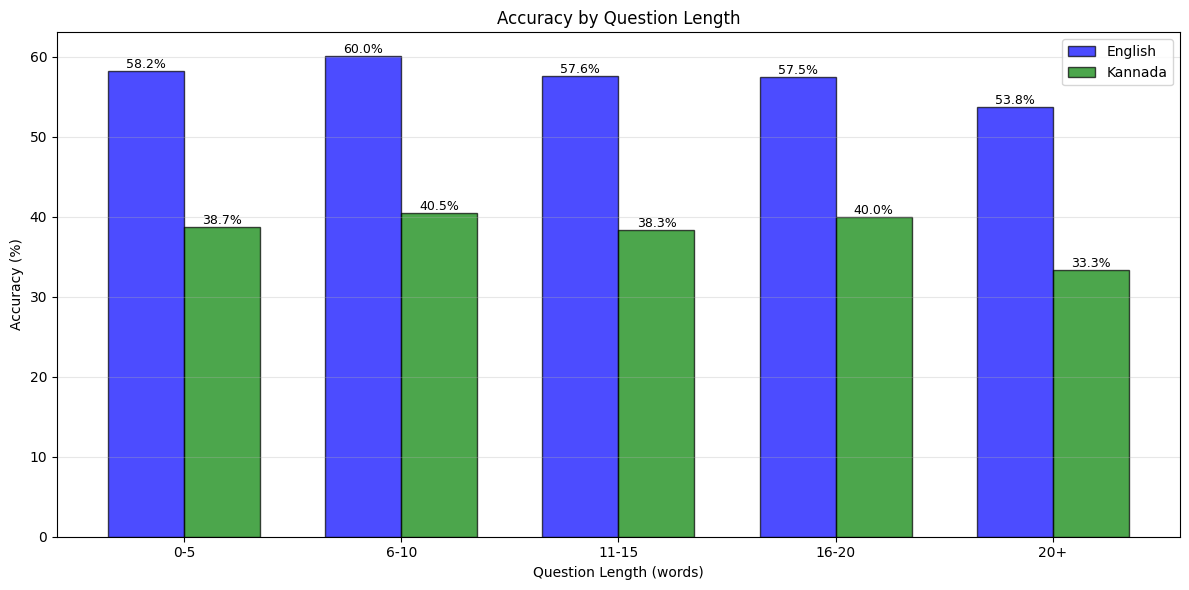

Saved: accuracy_by_question_length.png
Saved: error_analysis.csv

Sample Error Examples:

English Model Errors (5 samples):

1. Question: What was Isaac Newton's belief about God  on the theory of natural law?
   Expected: a rational god who established a law-abiding cosmos
   Predicted: rational god

2. Question: Who in medieval Europe obtained the sole rights to hunt in certain areas of a feudal territory?
   Expected: the upper class
   Predicted: upper class

3. Question: Which scientist experimented with blasting alpha particles at the nuclei of gold?
   Expected: ernest rutherford
   Predicted: feynman

4. Question: How have the friar organizations contributed to the struggle in Burma?
   Expected: monks' organisations that played a vital role in myanmar's struggle for democracy have taken measures to block any humanitarian assistance to the rohingya
   Predicted: measures to block any humanitarian assistance to the rohingya community

5. Question: What place did IGN give the gam

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

def analyze_errors(predictions, references, test_data, lang='English'):
    errors = []
    correct = []

    for pred, ref, example in zip(predictions, references, test_data):
        pred_text = pred['prediction_text'].strip().lower()
        ref_text = ref['answers']['text'][0].strip().lower()

        if pred_text == ref_text:
            correct.append({
                'question': example['question'],
                'prediction': pred_text,
                'reference': ref_text,
                'question_length': len(example['question'].split())
            })
        else:
            errors.append({
                'question': example['question'],
                'prediction': pred_text,
                'reference': ref_text,
                'question_length': len(example['question'].split()),
                'error_type': 'wrong_answer'
            })

    return errors, correct

eng_errors, eng_correct = analyze_errors(eng_predictions, eng_references, eng_test, 'English')
kan_errors, kan_correct = analyze_errors(kan_predictions, kan_references, kan_test, 'Kannada')

print("Error Analysis:")
print(f"\nEnglish Model:")
print(f"  Correct predictions: {len(eng_correct)} ({len(eng_correct)/len(eng_test)*100:.2f}%)")
print(f"  Incorrect predictions: {len(eng_errors)} ({len(eng_errors)/len(eng_test)*100:.2f}%)")

print(f"\nKannada Model:")
print(f"  Correct predictions: {len(kan_correct)} ({len(kan_correct)/len(kan_test)*100:.2f}%)")
print(f"  Incorrect predictions: {len(kan_errors)} ({len(kan_errors)/len(kan_test)*100:.2f}%)")

def analyze_by_question_length(correct, errors):
    all_examples = correct + errors

    length_bins = [0, 5, 10, 15, 20, 100]
    bin_labels = ['0-5', '6-10', '11-15', '16-20', '20+']

    accuracy_by_length = {}
    for label in bin_labels:
        accuracy_by_length[label] = {'correct': 0, 'total': 0}

    for ex in all_examples:
        length = ex['question_length']
        for i, (low, high) in enumerate(zip(length_bins[:-1], length_bins[1:])):
            if low < length <= high:
                accuracy_by_length[bin_labels[i]]['total'] += 1
                if ex in correct:
                    accuracy_by_length[bin_labels[i]]['correct'] += 1
                break

    return accuracy_by_length

eng_length_accuracy = analyze_by_question_length(eng_correct, eng_errors)
kan_length_accuracy = analyze_by_question_length(kan_correct, kan_errors)

print("\nGenerating accuracy by question length plot...")

fig, ax = plt.subplots(figsize=(12, 6))

labels = list(eng_length_accuracy.keys())
eng_acc = [eng_length_accuracy[l]['correct']/eng_length_accuracy[l]['total']*100
           if eng_length_accuracy[l]['total'] > 0 else 0 for l in labels]
kan_acc = [kan_length_accuracy[l]['correct']/kan_length_accuracy[l]['total']*100
           if kan_length_accuracy[l]['total'] > 0 else 0 for l in labels]

x = np.arange(len(labels))
width = 0.35

bars1 = ax.bar(x - width/2, eng_acc, width, label='English', color='blue', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, kan_acc, width, label='Kannada', color='green', alpha=0.7, edgecolor='black')

ax.set_xlabel('Question Length (words)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by Question Length')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('accuracy_by_question_length.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: accuracy_by_question_length.png")

error_analysis_df = pd.DataFrame({
    'Metric': [
        'Total Test Examples',
        'Correct Predictions',
        'Incorrect Predictions',
        'Accuracy (%)'
    ],
    'English': [
        len(eng_test),
        len(eng_correct),
        len(eng_errors),
        f"{len(eng_correct)/len(eng_test)*100:.2f}"
    ],
    'Kannada': [
        len(kan_test),
        len(kan_correct),
        len(kan_errors),
        f"{len(kan_correct)/len(kan_test)*100:.2f}"
    ]
})

error_analysis_df.to_csv('error_analysis.csv', index=False)
print("Saved: error_analysis.csv")

print("\nSample Error Examples:")
print("\nEnglish Model Errors (5 samples):")
for i, err in enumerate(eng_errors[:5]):
    print(f"\n{i+1}. Question: {err['question']}")
    print(f"   Expected: {err['reference']}")
    print(f"   Predicted: {err['prediction']}")

print("\nKannada Model Errors (5 samples):")
for i, err in enumerate(kan_errors[:5]):
    print(f"\n{i+1}. Question: {err['question']}")
    print(f"   Expected: {err['reference']}")
    print(f"   Predicted: {err['prediction']}")

print("\nComplete performance analysis finished.")